## 0: Setup

In [ ]:
import os, json, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json
import shutil

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT = Path.cwd().parent
BASE_DIR = ROOT / "MINI-DDSM-Complete-PNG-16"
DATA_XLSX = ROOT / "Data.xlsx"

OUT_DIR     = ROOT / "outputs"
METRICS_DIR = OUT_DIR / "metrics"
PLOTS_DIR   = OUT_DIR / "plots"
VQC_DIR     = OUT_DIR / "visual_qc"
MODELS_DIR = ROOT / "models"

for d in [OUT_DIR, METRICS_DIR, PLOTS_DIR, VQC_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

IMG_SIZE   = (224, 224)   # (W, H)
BATCH_SIZE = 16
CLASS_NAMES = ["Non-malignant", "Malignant"]

## 1: Helper Functions

In [ ]:
def infer_view(fn):
    s = str(fn).upper()
    if "MLO" in s: return "MLO"
    if "CC"  in s: return "CC"
    return "Unknown"

def infer_patient_id(fn):
    s = Path(fn).stem
    return s.split("_")[0] if "_" in s else s

def map_status_to_label_name(x):
    x = str(x).strip().lower()
    if x in ["cancer", "malignant", "malig"]: return "Malignant"
    if x in ["normal", "benign", "non-malignant", "nonmalignant"]: return "Non-malignant"
    return None

def resolve_path(pstr):
    if pd.isna(pstr): return None
    s = str(pstr).replace("\\", "/").strip()
    p = Path(s)
    if p.is_absolute():
        return str(p) if p.exists() else None
    q = (BASE_DIR / s).resolve()
    return str(q) if q.exists() else None


def trim_borders(img, frac=0.05, pad_ratio=0.015, close_kernel=7):
    # tiny uniform shave by fraction
    h, w = img.shape[:2]
    dy = max(1, int(h * frac))
    dx = max(1, int(w * frac))
    y0, y1 = dy, max(dy + 1, h - dy)
    x0, x1 = dx, max(dx + 1, w - dx)
    img = img[y0:y1, x0:x1]

    # Otsu -> largest component -> bbox + pad
    g = cv2.GaussianBlur(img, (5,5), 0)
    _, th = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if (th > 0).mean() > 0.5:
        th = cv2.bitwise_not(th)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((close_kernel, close_kernel), np.uint8), 1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return img

    x, y, bw, bh = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    pad = int(pad_ratio * max(bw, bh))
    x0 = max(0, x - pad);          y0 = max(0, y - pad)
    x1 = min(img.shape[1], x + bw + pad);  y1 = min(img.shape[0], y + bh + pad)

    if (x1 - x0) > 20 and (y1 - y0) > 20:
        return img[y0:y1, x0:x1]
    return img

def to_disp(x):
    x = x.astype(np.float32); mn, mx = x.min(), x.max()
    if mx - mn < 1e-6: return np.zeros_like(x)
    return np.clip((x - mn) / (mx - mn), 0, 1)

## 2: Path Checks

In [3]:
print("data_dir    :", BASE_DIR, "| exists:", BASE_DIR.exists())
print("meta_xlsx   :", DATA_XLSX, "| exists:", DATA_XLSX.exists())
print("metrics_dir :", METRICS_DIR, "| exists:", METRICS_DIR.exists())
print("visual_qc   :", VQC_DIR,    "| exists:", VQC_DIR.exists())

data_dir    : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/MINI-DDSM-Complete-PNG-16 | exists: True
meta_xlsx   : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/Data.xlsx | exists: True
metrics_dir : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics | exists: True
visual_qc   : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc | exists: True


## 3: Read Data and Build Dataframe

In [4]:
meta = pd.read_excel(DATA_XLSX)
meta.columns = [str(c).strip().lower() for c in meta.columns]

full_col   = next((c for c in meta.columns if c in ["fullpath","full_path","imagepath","image_path","filepath","path"]), None)
mask_col   = next((c for c in meta.columns if c in ["tumour_contour","tumor_contour","mask_path","mask","lesion_mask"]), None)
status_col = next((c for c in meta.columns if c in ["status","label","class","diagnosis"]), None)

if not full_col or not status_col:
    raise RuntimeError("Need fullPath + Status in Data.xlsx")

df = pd.DataFrame({
    "image_path": meta[full_col].apply(resolve_path),
    "mask_path":  meta[mask_col].apply(lambda x: None if (pd.isna(x) or str(x).strip() in ["-","","NA","na","None","none"]) else resolve_path(x)) if mask_col else None,
    "status":     meta[status_col].astype(str)
})

df = df.dropna(subset=["image_path"]).copy()
df["filename"]   = df["image_path"].apply(lambda s: Path(s).name)
df["label_name"] = df["status"].apply(map_status_to_label_name)
df = df.dropna(subset=["label_name"]).copy()
df["label"]      = (df["label_name"] == "Malignant").astype(int)
df["view"]       = df["filename"].apply(infer_view)
df["patient_id"] = df["filename"].apply(infer_patient_id)

print("rows:", len(df))
df.head(3)

rows: 6898


,image_path,mask_path,status,filename,label_name,label,view,patient_id
0,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_CC.png,Non-malignant,0,CC,C
1,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_MLO.png,Non-malignant,0,MLO,C
2,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,None,Benign,C_0029_1.RIGHT_CC.png,Non-malignant,0,CC,C


## 4: Clean Data

In [ ]:
# Cell 4 — Clean data + sanity checks (labels, leakage, corrupts)

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# remove mask files and duplicates
is_mask = df["filename"].str.contains("_Mask", case=False, na=False)
df_base = (
    df.loc[~is_mask]
      .drop_duplicates(subset=["image_path"])
      .reset_index(drop=True)
)

# drop unreadable/corrupted images (OpenCV + PIL verify)
def _ok_cv2(p):
    try:
        im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        return im is not None and im.size > 0
    except Exception:
        return False

def _ok_pil(p):
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False

bad_cv  = df_base.loc[~df_base["image_path"].map(_ok_cv2), "image_path"].astype(str).tolist()
left    = df_base.loc[~df_base["image_path"].isin(bad_cv)].copy()
bad_pil = left.loc[~left["image_path"].map(_ok_pil), "image_path"].astype(str).tolist()

bad_imgs = sorted(set(bad_cv) | set(bad_pil))
if bad_imgs:
    pd.DataFrame({"bad_image_path": bad_imgs}).to_csv(METRICS_DIR/"dropped_unreadable.csv", index=False)
    df_base = df_base[~df_base["image_path"].isin(bad_imgs)].reset_index(drop=True)

print(f"usable images: {len(df_base)}  (dropped unreadable: {len(bad_imgs)})")

# scrub masks
bad_masks = []
if "mask_path" in df_base.columns:
    mask_paths = df_base["mask_path"].dropna().astype(str).unique().tolist()
    bad_masks = [p for p in mask_paths if not _ok_pil(p)]
    if bad_masks:
        df_base.loc[df_base["mask_path"].isin(bad_masks), "mask_path"] = None
        pd.DataFrame({"bad_mask_path": bad_masks}).to_csv(METRICS_DIR/"unreadable_masks.csv", index=False)
print(f"unreadable masks (ignored later): {len(bad_masks)}")

# label sanity check: reconfirm mapping & counts
valid = {"Non-malignant", "Malignant"}
if not set(df_base["label_name"].unique()).issubset(valid):   # <-- fix here
    raise ValueError(f"Unexpected label_name(s): {set(df_base['label_name'].unique()) - valid}")

print("\nCounts by label_name:")
print(df_base["label_name"].value_counts())

libpng error: Read Error


usable images: 6897  (dropped unreadable: 1)
unreadable masks (ignored later): 0

Counts by label_name:
label_name
Non-malignant    4181
Malignant        2716
Name: count, dtype: int64


## 5: Data Summaries

In [6]:
summary = (
    df_base.groupby(["label_name","view"], dropna=False)
           .size().reset_index(name="n_images")
           .sort_values(["label_name","view"])
)
summary.to_csv(METRICS_DIR / "dataset_summary.csv", index=False)

patients = (
    df_base.groupby("label")["patient_id"].nunique()
           .rename("n_patients").reset_index()
)
patients["label_name"] = patients["label"].map({0:"Non-malignant",1:"Malignant"})
summary_total = (
    df_base.groupby("label_name").size()
           .rename("n_images_total").reset_index()
           .merge(patients[["label_name","n_patients"]], on="label_name", how="left")
)
summary_total.to_csv(METRICS_DIR / "dataset_summary_by_label.csv", index=False)

txt = []
txt.append(f"Total images (no _Mask): {len(df_base)}")
txt.append("By label:\n" + df_base["label_name"].value_counts().to_string())
txt.append("\nBy label x view:\n" + summary.to_string(index=False))
(METRICS_DIR / "dataset_summary.txt").write_text("\n".join(txt))

print("Saved dataset summaries to:", METRICS_DIR)
summary.head(), summary_total.head()

Saved dataset summaries to: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics


(      label_name view  n_images
 0      Malignant   CC      1358
 1      Malignant  MLO      1358
 2  Non-malignant   CC      2091
 3  Non-malignant  MLO      2090,
       label_name  n_images_total  n_patients
 0      Malignant            2716           4
 1  Non-malignant            4181           4)

## 6: Patient Level Split

In [7]:
X = df_base["filename"].values
y = df_base["label"].values
groups = df_base["patient_id"].values

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
train_idx, val_idx = next(skf.split(X, y, groups))

df_split = df_base.copy()
df_split["split"] = "train"
df_split.iloc[val_idx, df_split.columns.get_loc("split")] = "val"

cols = ["image_path","filename","label","label_name","patient_id","view","split"]
out_fp = METRICS_DIR / "split_manifest_v6.csv"
df_split[cols].to_csv(out_fp, index=False)

df_split["split"].value_counts()

split
train    5245
val      1652
Name: count, dtype: int64

## 7: Leakage Test, Class Weights

In [8]:
manifest = pd.read_csv(METRICS_DIR / "split_manifest_v6.csv")

leak = manifest.groupby("patient_id")["split"].nunique()
print("patient leakage:", (leak > 1).any())

by_label = manifest.groupby(["split","label_name"]).size().unstack(fill_value=0)
by_view  = manifest.groupby(["split","view"]).size().unstack(fill_value=0)
print("\nby_label:\n", by_label)
print("\nby_view:\n", by_view)

by_label.to_csv(METRICS_DIR / "split_counts_by_label.csv")
by_view.to_csv(METRICS_DIR / "split_counts_by_view.csv")

train = manifest[manifest["split"] == "train"]
n0 = (train["label"] == 0).sum()
n1 = (train["label"] == 1).sum()
N  = n0 + n1
class_weights = {0: float(N/(2*max(n0,1))), 1: float(N/(2*max(n1,1)))}
with open(METRICS_DIR / "class_weights.json", "w") as f:
    json.dump(class_weights, f, indent=2)

print("\nclass_weights:", class_weights)

# Hard assert: no patient appears in both splits
overlap = (
    set(manifest.loc[manifest["split"]=="train","patient_id"])
    & set(manifest.loc[manifest["split"]=="val","patient_id"])
)
assert len(overlap) == 0, f"Patient leakage detected for {len(overlap)} patients, e.g. {sorted(list(overlap))[:5]}"
print("Patient leakage: False (no overlap)")

patient leakage: False

by_label:
 label_name  Malignant  Non-malignant
split                               
train            1784           3461
val               932            720

by_view:
 view     CC   MLO
split            
train  2623  2622
val     826   826

class_weights: {0: 0.7577289800635655, 1: 1.4700112107623318}
Patient leakage: False (no overlap)


## 8: Mask Map, Quality Check Table

In [9]:
# Cell 8 — Mask QC (v6)

manifest = pd.read_csv(METRICS_DIR / "split_manifest_v6.csv")
meta = pd.read_excel(DATA_XLSX)
meta.columns = [str(c).strip().lower() for c in meta.columns]

full_opts = ["fullpath","full_path","imagepath","image_path","filepath","path"]
mask_opts = ["tumour_contour","tumor_contour","mask_path","mask","lesion_mask"]
full_col = next((c for c in meta.columns if c in full_opts), None)
mask_col = next((c for c in meta.columns if c in mask_opts), None)
if full_col is None: raise ValueError("Image path column not found in Data.xlsx")

# filename + (resolved) mask_path
if mask_col:
    mask_map = meta[[full_col, mask_col]].copy()
else:
    mask_map = meta[[full_col]].copy(); mask_map["dummy"] = None; mask_col = "dummy"

mask_map = (
    mask_map
    .assign(
        filename = mask_map[full_col].astype(str).map(lambda s: Path(s).name if s else None),
        mask_path = mask_map[mask_col]
            .astype(str)
            .str.strip()
            .replace({"-": "", "NA": "", "na": "", "None": "", "none": ""})
            .map(lambda s: resolve_path(s) if s else None)
    )[["filename","mask_path"]]
    .dropna(subset=["filename"])
    .drop_duplicates(subset=["filename"])
)

mf = manifest.merge(mask_map, on="filename", how="left")

def neighbour_mask(ip):
    p = Path(ip); q = p.with_name(p.stem + "_Mask" + p.suffix)
    return str(q) if q.exists() else None

mf["resolved_mask_path"] = mf["mask_path"].where(mf["mask_path"].notna(),
                                                 mf["image_path"].map(neighbour_mask))

def mask_nonzero(mp):
    if not isinstance(mp, str) or not mp or not Path(mp).exists(): return False
    m = cv2.imread(str(mp), 0)
    return (m is not None) and (m.max() > 0)

mf["has_nonzero_mask"] = mf["resolved_mask_path"].map(mask_nonzero)

cols = ["image_path","filename","label","label_name","patient_id","view","split",
        "resolved_mask_path","has_nonzero_mask"]
out_csv = METRICS_DIR / "mask_qc_v6.csv"
mf[cols].to_csv(out_csv, index=False)
print("Saved:", out_csv, "| usable masks:", int(mf["has_nonzero_mask"].sum()))

Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics/mask_qc_v6.csv | usable masks: 2830


## 9: Save Mask Overlay

In [10]:
# Cell 9 — Mask overlays (v6)

OVERLAY_DIR = VQC_DIR / "mask_overlays_v6"
DEBUG_DIR   = VQC_DIR / "mask_overlays_debug_v6"
OVERLAY_DIR.mkdir(parents=True, exist_ok=True); DEBUG_DIR.mkdir(parents=True, exist_ok=True)

pairs = (
    pd.read_csv(METRICS_DIR / "mask_qc_v6.csv")
      .query("has_nonzero_mask == True")
      [["image_path","resolved_mask_path"]]
      .dropna()
      .head(24)
)

saved = 0
for ip, mp in pairs.itertuples(index=False):
    img, m = cv2.imread(str(ip), 0), cv2.imread(str(mp), 0)
    if img is None or m is None: continue
    if m.shape != img.shape: m = cv2.resize(m, (img.shape[1], img.shape[0]), cv2.INTER_NEAREST)

    binm = m > 0
    if binm.mean() > 0.5: binm = ~binm
    binm = cv2.dilate(binm.astype(np.uint8), np.ones((5,5), np.uint8), 1).astype(bool)

    img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    red = img3.copy(); red[binm] = (0,0,255)
    overlay = cv2.addWeighted(img3, 0.7, red, 0.6, 0)

    stem = Path(ip).stem
    cv2.imwrite(str(OVERLAY_DIR / f"{stem}_overlay_v6.png"), overlay)

    mu8 = (binm.astype(np.uint8) * 255)
    jet = cv2.applyColorMap(mu8, cv2.COLORMAP_JET)
    panel = np.hstack([img3, cv2.cvtColor(mu8, cv2.COLOR_GRAY2BGR),
                       cv2.addWeighted(img3, 0.7, jet, 0.6, 0)])
    cv2.imwrite(str(DEBUG_DIR / f"{stem}_debug_v6.png"), panel)
    saved += 1

print("overlays saved:", saved, "->", OVERLAY_DIR)

overlays saved: 24 -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/mask_overlays_v6


## 10: Augmentation

In [ ]:
# Cell 10 Augmentation (v6)

os.environ["OPENCV_LOG_LEVEL"] = "ERROR"
cv2.setNumThreads(0)
tf.get_logger().setLevel(logging.ERROR)

manifest = pd.read_csv(METRICS_DIR / "split_manifest_v6.csv")
mask_qc  = pd.read_csv(METRICS_DIR / "mask_qc_v6.csv")[["image_path","resolved_mask_path","has_nonzero_mask"]]

train_df = manifest[manifest["split"] == "train"].merge(mask_qc, on="image_path", how="left").reset_index(drop=True)
val_df   = manifest[manifest["split"] == "val"  ].merge(mask_qc, on="image_path", how="left").reset_index(drop=True)

BATCH_SIZE = 8
H, W = IMG_SIZE[1], IMG_SIZE[0]

aug_layers = [
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.05, fill_mode="constant", fill_value=0.0, seed=SEED),
    tf.keras.layers.RandomZoom(0.10, fill_mode="constant", fill_value=0.0, seed=SEED),
    tf.keras.layers.RandomTranslation(0.10, 0.10, fill_mode="constant", fill_value=0.0, seed=SEED),
    tf.keras.layers.RandomContrast(0.10, seed=SEED),
]
if hasattr(tf.keras.layers, "RandomBrightness"):
    aug_layers.append(tf.keras.layers.RandomBrightness(0.10, value_range=(0.0, 1.0), seed=SEED))
aug = tf.keras.Sequential(aug_layers, name="aug")

def _decode(t):
    if isinstance(t, (bytes, bytearray)): return t.decode("utf-8")
    if isinstance(t, tf.Tensor):
        v = t.numpy()
        return v.decode("utf-8") if isinstance(v, (bytes, bytearray)) else str(v)
    return str(t)

def _crop_with_mask(img_g, mask_path):
    try:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if m is None or m.size == 0: 
            return None
        if m.shape != img_g.shape:
            m = cv2.resize(m, (img_g.shape[1], img_g.shape[0]), interpolation=cv2.INTER_NEAREST)
        pts = cv2.findNonZero((m > 0).astype(np.uint8))
        if pts is None:
            return None
        x,y,w,h = cv2.boundingRect(pts)
        return img_g[y:y+h, x:x+w]
    except Exception:
        return None

def _letterbox_gray(g, target_hw):
    th, tw = target_hw
    h, w = g.shape[:2]
    r = min(tw / max(w,1), th / max(h,1))
    nw, nh = max(1, int(w * r)), max(1, int(h * r))
    resized = cv2.resize(g, (nw, nh), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((th, tw), dtype=resized.dtype)
    y0 = (th - nh) // 2; x0 = (tw - nw) // 2
    canvas[y0:y0+nh, x0:x0+nw] = resized
    return canvas

def _load_preprocess_numpy(path_like, mask_like, has_mask_like):
    p = _decode(path_like)
    mp = _decode(mask_like) if mask_like is not None else None
    hasm = bool(has_mask_like)

    if not p or not os.path.exists(p):
        return np.zeros((H, W, 3), dtype="float32")

    g = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if g is None or g.size == 0:
        return np.zeros((H, W, 3), dtype="float32")

    cropped = None
    if hasm and mp and os.path.exists(mp):
        cropped = _crop_with_mask(g, mp)

    g = cropped if cropped is not None else trim_borders(g)
    g = _letterbox_gray(g, (H, W))

    g01 = (g.astype("float32") / 255.0)
    x3  = np.stack([g01, g01, g01], axis=-1)
    return x3

def _map_fn(path, label, mask_path, has_mask, training):
    x = tf.py_function(func=_load_preprocess_numpy, inp=[path, mask_path, has_mask], Tout=tf.float32)
    x.set_shape((H, W, 3))
    if training:
        x = aug(x, training=True)
    x = vgg_preprocess(x * 255.0)

    y = tf.cast(label, tf.float32)
    y = tf.reshape(y, (1,))
    return x, y

def make_ds(df, training=True):
    paths  = df["image_path"].astype(str).values
    labels = df["label"].astype(np.float32).values
    masks  = df["resolved_mask_path"].fillna("").astype(str).values
    hasm   = df["has_nonzero_mask"].fillna(False).astype(bool).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, masks, hasm))
    opts = tf.data.Options(); opts.experimental_deterministic = True
    ds = ds.with_options(opts)

    if training:
        ds = ds.shuffle(buffer_size=min(len(df), 2048), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(lambda p, y, mp, hm: _map_fn(p, y, mp, hm, training),
                num_parallel_calls=1)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)

print("train samples:", len(train_df), " | val samples:", len(val_df))
print("IMG_SIZE:", IMG_SIZE, "| preprocessing: letterbox + VGG preprocess | aug on TRAIN only")

train samples: 5245  | val samples: 1652
IMG_SIZE: (224, 224) | preprocessing: letterbox + VGG preprocess | aug on TRAIN only


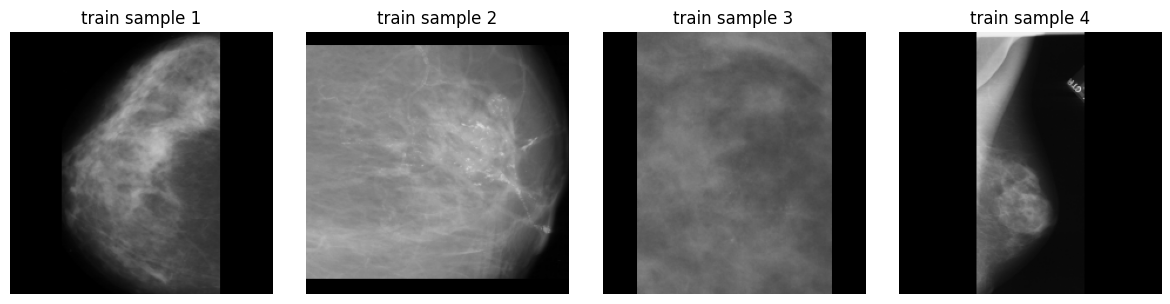

In [12]:
# Cell 10b — Quick visual sanity check (one small batch)

def _show_sample_from_train(n=4):
    preview = []
    for i, row in train_df.sample(min(n, len(train_df)), random_state=SEED).iterrows():
        img = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        crop = _crop_with_mask(img, row.get("resolved_mask_path")) if row.get("has_nonzero_mask") else None
        img  = crop if crop is not None else trim_borders(img)
        img  = _letterbox_gray(img, (H, W))
        preview.append(img)
        if len(preview) >= n: break

    cols = len(preview)
    plt.figure(figsize=(3*cols, 3))
    for i, im in enumerate(preview, 1):
        ax = plt.subplot(1, cols, i)
        ax.imshow(im, cmap="gray", vmin=0, vmax=255)
        ax.set_axis_off(); ax.set_title(f"train sample {i}")
    plt.tight_layout(); plt.show()

_show_sample_from_train(n=4)

## 11: Augmentation Preview

Saved 8 raw/trim/aug grids -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/aug_previews_v6


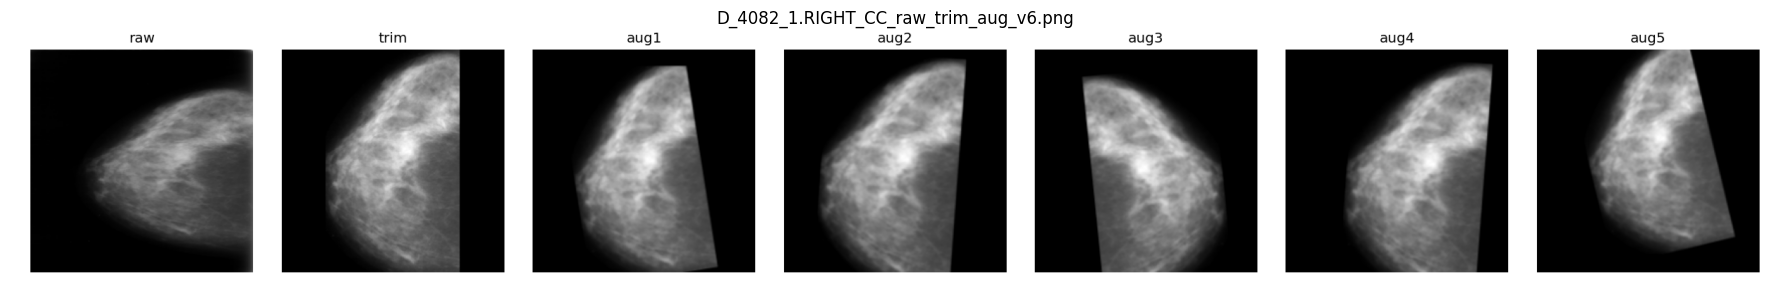

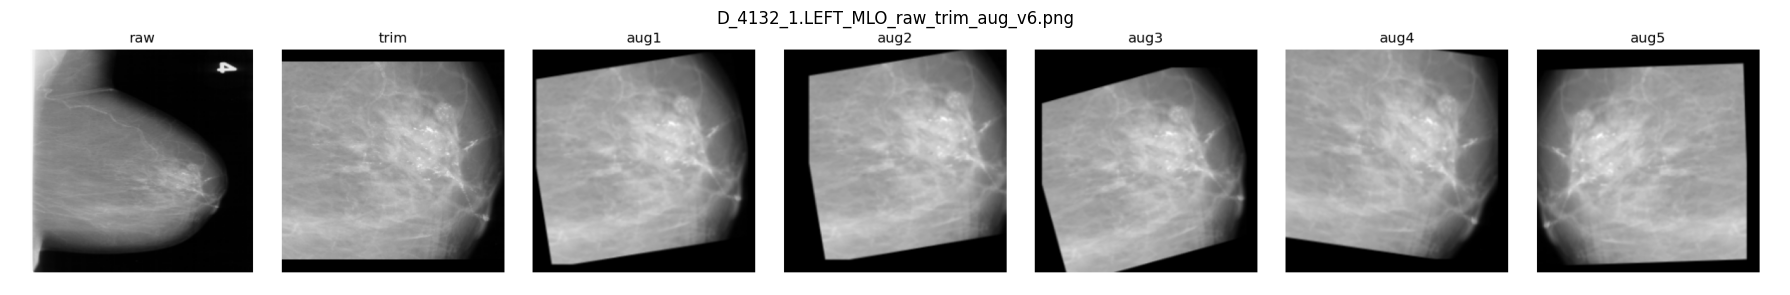

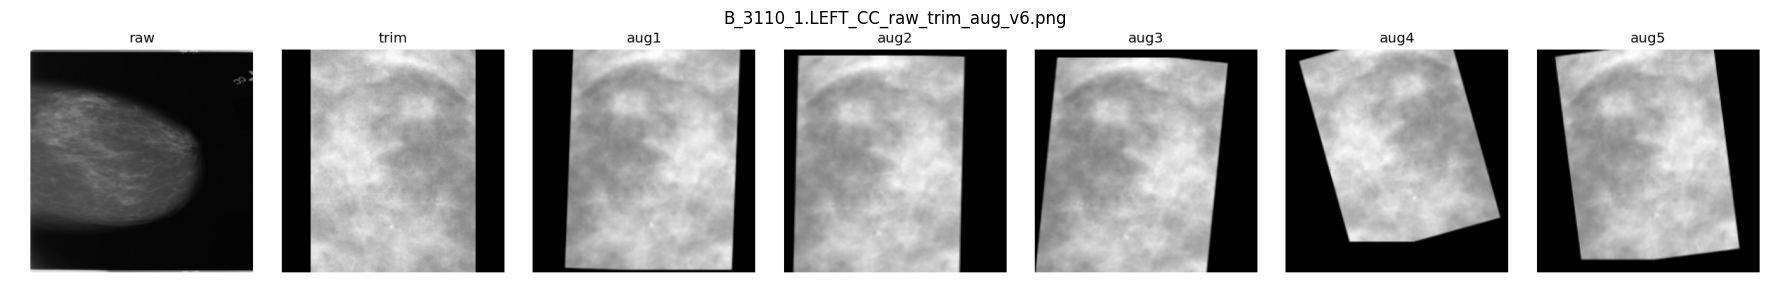

In [ ]:
# Cell 11 — Augmentation previews (v6)

preview_dir = VQC_DIR / "aug_previews_v6"
preview_dir.mkdir(parents=True, exist_ok=True)

N_IMAGES  = 8
N_AUGS    = 5
N_PREVIEW = 3

def _load_raw_gray_resized(path_str, size):
    img = cv2.imread(str(path_str), cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return (img / 255.0).astype("float32")

sample_rows = (
    train_df.sample(min(N_IMAGES, len(train_df)), random_state=SEED)
            [["image_path","resolved_mask_path","has_nonzero_mask"]]
            .to_dict("records")
)

saved, preview_paths = 0, []
for r in sample_rows:
    ip = r["image_path"]
    mp = r.get("resolved_mask_path") or ""
    hm = bool(r.get("has_nonzero_mask", False))

    raw = _load_raw_gray_resized(ip, IMG_SIZE)
    trimmed = _load_preprocess_numpy(ip, mp, hm)
    if raw is None or trimmed is None: 
        continue

    x0 = tf.convert_to_tensor(trimmed[None, ...], dtype=tf.float32)

    ims = [raw, to_disp(trimmed[..., 0])]
    for _ in range(N_AUGS):
        ims.append(to_disp(aug(x0, training=True)[0].numpy()[..., 0]))

    titles = ["raw", "trim"] + [f"aug{i+1}" for i in range(N_AUGS)]
    cols = len(ims)
    plt.figure(figsize=(3*cols, 3))
    for i, im in enumerate(ims):
        ax = plt.subplot(1, cols, i+1)
        ax.imshow(np.squeeze(im), cmap="gray", vmin=0, vmax=1)
        ax.set_axis_off(); ax.set_title(titles[i])
    out_path = preview_dir / (Path(ip).stem + "_raw_trim_aug_v6.png")
    plt.tight_layout(); plt.savefig(out_path, dpi=120); plt.close()

    if len(preview_paths) < N_PREVIEW:
        preview_paths.append(out_path)

    saved += 1

print(f"Saved {saved} raw/trim/aug grids ->", preview_dir)

# display each selected strip on its own line
for p in preview_paths:
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 3))
    plt.imshow(img); plt.axis("off"); plt.title(Path(p).name)
    plt.tight_layout(); plt.show()

## 12: Model Build

In [14]:
# Cell 12 — Model builder (v6)

def build_backbone(name, input_shape):
    if name.lower() == "vgg16":
        return VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name.lower() == "resnet50":
        return ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("backbone not supported")

def build_model(name="vgg16"):
    base = build_backbone(name, IMG_SIZE + (3,))

    if name.lower() == "vgg16":
        for l in base.layers[:-4]:
            l.trainable = False
        unf = "unfrozen last 4 conv layers"
    else:  # resnet50
        for l in base.layers[:-10]:
            l.trainable = False
        unf = "unfrozen last ~10 layers"

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=base.input, outputs=out, name=f"{name}_miniddsm_v6")
    return model, unf

def compile_model(model, lr=1e-4):
    opt = Adam(learning_rate=lr)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

WARMUP_EPOCHS = 8
es = EarlyStopping(
    monitor="val_auc", mode="max", patience=3, restore_best_weights=True, verbose=1
)

## 13: Warm-up Training (VGG16 vs ResNet50)

In [ ]:
# Cell 13 — Warm-up training (v6)

results = []

candidates = ["vgg16", "resnet50"]
for name in candidates:
    print(f"\n Warm-up training: {name.upper()} ")
    model, note = build_model(name)
    compile_model(model, lr=1e-4)

    ckpt_path = MODELS_DIR / f"tmp_{name}v6.keras"
    ckpt = ModelCheckpoint(
        filepath=str(ckpt_path),
        monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=False, verbose=1
    )
    ton = TerminateOnNaN()
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=WARMUP_EPOCHS,
        class_weight=class_weights,
        callbacks=[es, ckpt, ton],
        verbose=1,
    )

    best = tf.keras.models.load_model(ckpt_path)
    val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)

    results.append({
        "backbone": name,
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "val_auc": float(val_auc),
        "unfreeze_note": note
    })
    print(f"{name}: val_acc={val_acc:.3f}  val_auc={val_auc:.3f}  ({note})")

res_df = pd.DataFrame(results).sort_values("val_auc", ascending=False)
print("\n Warm-up results")
print(res_df.to_string(index=False))

cmp_path = METRICS_DIR / "baseline_compare_v6.csv"
res_df.to_csv(cmp_path, index=False)
print("\nSaved:", cmp_path)

best_name = res_df.iloc[0]["backbone"]
if best_name == "vgg16":
    last_conv = "block5_conv3"
else:
    last_conv = "conv5_block3_out"  # <-- fix

# save winner
best_ckpt = MODELS_DIR / f"tmp_{best_name}v6.keras"
final_path = MODELS_DIR / "best_model_v6.keras"
Path(final_path).write_bytes(Path(best_ckpt).read_bytes())
print(f"\nWinner: {best_name.upper()}  | saved -> {final_path}")

CHOSEN_BACKBONE = best_name
CHOSEN_LAST_CONV = last_conv
print("Backbone:", CHOSEN_BACKBONE, "| Grad-CAM layer:", CHOSEN_LAST_CONV)


 Warm-up training: VGG16 
Epoch 1/8
656/656 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.5741 - auc: 0.6222
Epoch 1: val_auc improved from -inf to 0.46494, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v6.keras
656/656 [==============================] - 603s 918ms/step - loss: 0.9986 - accuracy: 0.5741 - auc: 0.6222 - val_loss: 2.5499 - val_accuracy: 0.4407 - val_auc: 0.4649
Epoch 2/8
656/656 [==============================] - ETA: 0s - loss: 0.8178 - accuracy: 0.6193 - auc: 0.6843
Epoch 2: val_auc improved from 0.46494 to 0.57690, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v6.keras
656/656 [==============================] - 591s 900ms/step - loss: 0.8178 - accuracy: 0.6193 - auc: 0.6843 - val_loss: 0.8743 - val_accuracy: 0.6041 - val_auc: 0.5769
Epoch 3/8
656/656 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.6318 - auc: 0.7013

## 14: Full Training

In [ ]:
# Cell 14 — Full training (v6)

best_ckpt_v6    = MODELS_DIR / "best_model_v6.keras"

# outputs
final_ckpt_path = MODELS_DIR / "best_model_full_v6.keras"
csv_out = METRICS_DIR / "train_full_log_v6.csv"

model = tf.keras.models.load_model(best_ckpt_v6)
compile_model(model, lr=1e-4)

# callbacks
es  = EarlyStopping(
    monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1
)
rlr = ReduceLROnPlateau(
    monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)
ckpt = ModelCheckpoint(
    filepath=str(final_ckpt_path),
    monitor="val_auc", mode="max",
    save_best_only=True, save_weights_only=False, verbose=1
)
csv = CSVLogger(str(csv_out), append=False)
ton = TerminateOnNaN()

EPOCHS_FULL = 50
start_epoch = 0
while True:
    try:
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS_FULL,
            initial_epoch=start_epoch,
            class_weight=class_weights,
            callbacks=[es, rlr, ckpt, csv, ton],
            verbose=1,
        )
        break
    except Exception as e:
        if "IOStream.flush timed out" in str(e):
            print("\nIO flush timed out; resuming training...")
            # resume from CSV row count
            try:
                start_epoch = int(pd.read_csv(METRICS_DIR / "train_full_log_v6.csv").shape[0])
            except Exception:
                start_epoch += 1
            continue
        else:
            raise

best = tf.keras.models.load_model(final_ckpt_path)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nBest checkpoint -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", final_ckpt_path)

Epoch 1/50
656/656 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.7203 - auc: 0.8057
Epoch 1: val_auc improved from -inf to 0.63143, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6.keras
656/656 [==============================] - 547s 831ms/step - loss: 0.5785 - accuracy: 0.7203 - auc: 0.8057 - val_loss: 0.9110 - val_accuracy: 0.5484 - val_auc: 0.6314 - lr: 1.0000e-04
Epoch 2/50
656/656 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7171 - auc: 0.8093
Epoch 2: val_auc improved from 0.63143 to 0.67342, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6.keras
656/656 [==============================] - 542s 827ms/step - loss: 0.5672 - accuracy: 0.7171 - auc: 0.8093 - val_loss: 0.7212 - val_accuracy: 0.6326 - val_auc: 0.6734 - lr: 1.0000e-04
Epoch 3/50
656/656 [==============================] - ETA: 0s - loss: 0.5598 - accura

In [ ]:
# Cell 14a — Full training resnet (retry) (v6)

best_ckpt_v6    = MODELS_DIR / "best_model_v6.keras"

# outputs
final_ckpt_path = MODELS_DIR / "best_model_full_v6.keras"
csv_out = METRICS_DIR / "train_full_log_v6.csv"

model = tf.keras.models.load_model(best_ckpt_v6)
compile_model(model, lr=1e-4)

# callbacks
es  = EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(final_ckpt_path), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(csv_out), append=False)
ton = TerminateOnNaN()

EPOCHS_FULL = 50
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FULL,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(final_ckpt_path)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nBest checkpoint -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", final_ckpt_path)

Epoch 1/50
656/656 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7241 - auc: 0.8141
Epoch 1: val_auc improved from -inf to 0.62134, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6.keras
656/656 [==============================] - 552s 838ms/step - loss: 0.5717 - accuracy: 0.7241 - auc: 0.8141 - val_loss: 0.7527 - val_accuracy: 0.5823 - val_auc: 0.6213 - lr: 1.0000e-04
Epoch 2/50
656/656 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7224 - auc: 0.8128
Epoch 2: val_auc did not improve from 0.62134
656/656 [==============================] - 550s 838ms/step - loss: 0.5657 - accuracy: 0.7224 - auc: 0.8128 - val_loss: 0.8500 - val_accuracy: 0.5490 - val_auc: 0.5908 - lr: 1.0000e-04
Epoch 3/50
656/656 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7222 - auc: 0.8184
Epoch 3: val_auc improved from 0.62134 to 0.63497, saving model to /Users/dash/Desktop/SIMNote

In [ ]:
# Cell 14a — Resume full training ResNet (v6)

old_final_ckpt = MODELS_DIR / "best_model_full_v6.keras"
old_csv        = METRICS_DIR / "train_full_log_v6.csv"
resume_ckpt    = MODELS_DIR / "best_model_full_v6_resume.keras"
resume_csv     = METRICS_DIR / "train_full_log_v6_resume.csv"

src = resume_ckpt if resume_ckpt.exists() else old_final_ckpt
assert src.exists(), f"Checkpoint not found: {src}"
print("Loading:", src.name)
model = tf.keras.models.load_model(src)

def _best(csv_path):
    try:
        d = pd.read_csv(csv_path)
        return len(d), (d["val_auc"].max() if "val_auc" in d else None)
    except Exception:
        return 0, None

n_old, best_old = _best(old_csv)
n_new, best_new = _best(resume_csv)
start_epoch = n_old + n_new
prev_best = max([x for x in [best_old, best_new] if x is not None], default=None)
print(f"Resuming at epoch {start_epoch} (prev best val_auc={prev_best})")

compile_model(model, lr=1e-4)

es  = EarlyStopping(monitor="val_auc", mode="max", patience=8,
                    restore_best_weights=True, verbose=1,
                    baseline=prev_best if prev_best is not None else None)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(resume_ckpt), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv  = CSVLogger(str(resume_csv), append=True)
ton  = TerminateOnNaN()

EPOCHS_FULL = 50
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FULL,
          initial_epoch=start_epoch, class_weight=class_weights,
          callbacks=[es, rlr, ckpt, csv, ton], verbose=1)

best = tf.keras.models.load_model(resume_ckpt)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nResumed best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved ->", resume_ckpt, "| Log ->", resume_csv)

Loading checkpoint: best_model_full_v6.keras
Resuming at epoch 12 (prev best val_auc=0.6667940616607666)
Epoch 13/50
656/656 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7634 - auc: 0.8561
Epoch 13: val_auc improved from -inf to 0.63263, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_resume.keras
656/656 [==============================] - 555s 844ms/step - loss: 0.5089 - accuracy: 0.7634 - auc: 0.8561 - val_loss: 1.0501 - val_accuracy: 0.5539 - val_auc: 0.6326 - lr: 1.0000e-04
Epoch 14/50
656/656 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.7653 - auc: 0.8618
Epoch 14: val_auc improved from 0.63263 to 0.68993, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_resume.keras
656/656 [==============================] - 547s 834ms/step - loss: 0.5008 - accuracy: 0.7653 - auc: 0.8618 - val_loss: 0.7850 - val_accuracy: 0.61

In [ ]:
# Cell 14b — Fine-tune

UNFREEZE_CONV = 14

src = MODELS_DIR / "best_model_full_v6_resume.keras"
print("Fine-tuning from:", src.name)
model = tf.keras.models.load_model(src)

# unfreeze last N convs; keep BN frozen; head trainable
def set_trainable_tail(m, n_conv, freeze_bn=True):
    conv_layers = [l for l in m.layers if isinstance(l, Conv2D)]
    for l in conv_layers: l.trainable = False
    for l in conv_layers[-n_conv:]: l.trainable = True
    for l in m.layers:
        if isinstance(l, (Dense, Dropout, GlobalAveragePooling2D)): l.trainable = True
        if freeze_bn and isinstance(l, BatchNormalization): l.trainable = False
    print(f"Conv2D trainable: {sum(int(l.trainable) for l in conv_layers)} / {len(conv_layers)} | n_conv={n_conv}")

set_trainable_tail(model, n_conv=UNFREEZE_CONV, freeze_bn=True)

model.compile(optimizer=Adam(learning_rate=2e-6, clipnorm=1.0),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# outputs
ckpt_out = MODELS_DIR / "best_model_full_v6_finetune.keras"
csv_out  = METRICS_DIR / "train_full_log_v6_finetune.csv"

# callbacks
es  = EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=5e-7, verbose=1)
ckpt = ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max", save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(csv_out), append=False)
ton = TerminateOnNaN()

FT_EPOCHS = 30
hist = model.fit(train_ds, validation_data=val_ds, epochs=FT_EPOCHS,
                 class_weight=class_weights, callbacks=[es, rlr, ckpt, csv, ton], verbose=1)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nFine-tuned best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", ckpt_out)

Fine-tuning from: best_model_full_v6_resume.keras
Conv2D trainable: 14 / 53 | n_conv=14
Epoch 1/30
656/656 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8170 - auc: 0.9000
Epoch 1: val_auc improved from -inf to 0.66303, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_finetune.keras
656/656 [==============================] - 568s 860ms/step - loss: 0.4075 - accuracy: 0.8170 - auc: 0.9000 - val_loss: 1.0885 - val_accuracy: 0.5908 - val_auc: 0.6630 - lr: 2.0000e-06
Epoch 2/30
656/656 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8437 - auc: 0.9205
Epoch 2: val_auc improved from 0.66303 to 0.67345, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_finetune.keras
656/656 [==============================] - 580s 884ms/step - loss: 0.3681 - accuracy: 0.8437 - auc: 0.9205 - val_loss: 0.9729 - val_accuracy: 0.6005 - val_auc: 0.6

In [ ]:
# Cell 14c — Full training VGG16 (v6_vgg16)

vgg_ckpt = MODELS_DIR / "tmp_vgg16v6.keras"
assert vgg_ckpt.exists(), f"Missing VGG16 warm-up checkpoint: {vgg_ckpt}"


final_ckpt_path = MODELS_DIR / "best_model_full_v6_vgg16.keras"
csv_out         = METRICS_DIR / "train_full_log_v6_vgg16.csv"

print("Full training from VGG16 warm-up:", vgg_ckpt.name)
model = tf.keras.models.load_model(vgg_ckpt)
compile_model(model, lr=1e-4)

es  = EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(final_ckpt_path), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv  = CSVLogger(str(csv_out), append=False)
ton  = TerminateOnNaN()

EPOCHS_FULL = 30
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FULL,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(final_ckpt_path)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\n[VGG16] Best checkpoint -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", final_ckpt_path)

Full training from VGG16 warm-up: tmp_vgg16v6.keras
Epoch 1/30
656/656 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.6576 - auc: 0.7296
Epoch 1: val_auc improved from -inf to 0.53603, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_vgg16.keras
656/656 [==============================] - 591s 897ms/step - loss: 0.7071 - accuracy: 0.6576 - auc: 0.7296 - val_loss: 0.8546 - val_accuracy: 0.5121 - val_auc: 0.5360 - lr: 1.0000e-04
Epoch 2/30
656/656 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.6562 - auc: 0.7402
Epoch 2: val_auc improved from 0.53603 to 0.55373, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_vgg16.keras
656/656 [==============================] - 581s 885ms/step - loss: 0.6709 - accuracy: 0.6562 - auc: 0.7402 - val_loss: 1.0222 - val_accuracy: 0.5115 - val_auc: 0.5537 - lr: 1.0000e-04
Epoch 3/30
656/656 [=

In [ ]:
# Cell 14c — Resume full training VGG16 (v6_vgg16_resume)

src_ckpt = MODELS_DIR / "best_model_full_v6_vgg16.keras"
print("Resuming VGG16 from:", src_ckpt.name)
model = tf.keras.models.load_model(src_ckpt)

compile_model(model, lr=1e-4)

resume_ckpt = MODELS_DIR / "best_model_full_v6_vgg16_resume.keras"
resume_csv  = METRICS_DIR / "train_full_log_v6_vgg16_resume.csv"

es  = EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(resume_ckpt), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv  = CSVLogger(str(resume_csv), append=False)
ton  = TerminateOnNaN()

EPOCHS_RESUME = 30
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_RESUME,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(resume_ckpt)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\n[VGG16 resume] Best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", resume_ckpt)

Resuming VGG16 from: best_model_full_v6_vgg16.keras
Epoch 1/30
656/656 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6704 - auc: 0.7494
Epoch 1: val_auc improved from -inf to 0.61470, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_vgg16_resume.keras
656/656 [==============================] - 577s 878ms/step - loss: 0.6655 - accuracy: 0.6704 - auc: 0.7494 - val_loss: 0.8982 - val_accuracy: 0.5769 - val_auc: 0.6147 - lr: 1.0000e-04
Epoch 2/30
656/656 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6597 - auc: 0.7340
Epoch 2: val_auc did not improve from 0.61470
656/656 [==============================] - 575s 877ms/step - loss: 0.6983 - accuracy: 0.6597 - auc: 0.7340 - val_loss: 0.9999 - val_accuracy: 0.5466 - val_auc: 0.5907 - lr: 1.0000e-04
Epoch 3/30
656/656 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.6812 - auc: 0.7699
Epoch 3: val_auc improved fro

In [ ]:
# Cell 14d — Fine-tune VGG16 (v6_vgg16_finetune)

src = MODELS_DIR / "best_model_full_v6_vgg16_resume.keras"
print("Fine-tuning VGG16 from:", src.name)
model = tf.keras.models.load_model(src)

def unfreeze_tail(m, n=8):
    convs = [l for l in m.layers if isinstance(l, Conv2D)]
    for l in convs[-n:]:
        l.trainable = True
    for l in m.layers:
        if isinstance(l, (Dense, Dropout, GlobalAveragePooling2D)):
            l.trainable = True
    print("Conv2D trainable:", sum(int(l.trainable) for l in convs), "/", len(convs))

unfreeze_tail(model, n=8)

model.compile(
    optimizer=Adam(learning_rate=2e-6, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_out = MODELS_DIR / "best_model_full_v6_vgg16_finetune.keras"
csv_out  = METRICS_DIR / "train_full_log_v6_vgg16_finetune.csv"

es  = EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=5e-7, verbose=1)
ckpt = ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv  = CSVLogger(str(csv_out), append=False)
ton  = TerminateOnNaN()

FT_EPOCHS = 30
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\n[VGG16 finetune] Best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", ckpt_out)

Fine-tuning VGG16 from: best_model_full_v6_vgg16_resume.keras
Conv2D trainable: 8 / 13
Epoch 1/30
656/656 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7314 - auc: 0.8191
Epoch 1: val_auc improved from -inf to 0.59164, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_vgg16_finetune.keras
656/656 [==============================] - 693s 1s/step - loss: 0.5381 - accuracy: 0.7314 - auc: 0.8191 - val_loss: 1.2437 - val_accuracy: 0.5309 - val_auc: 0.5916 - lr: 2.0000e-06
Epoch 2/30
656/656 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7161 - auc: 0.8057
Epoch 2: val_auc improved from 0.59164 to 0.59510, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v6_vgg16_finetune.keras
656/656 [==============================] - 726s 1s/step - loss: 0.5762 - accuracy: 0.7161 - auc: 0.8057 - val_loss: 1.3627 - val_accuracy: 0.5406 - val_auc

## 15: Evaluation

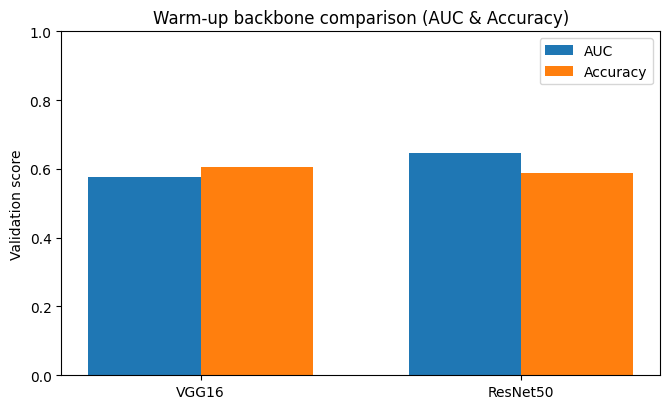

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/warmup_backbone_compare_auc_acc_v6.png


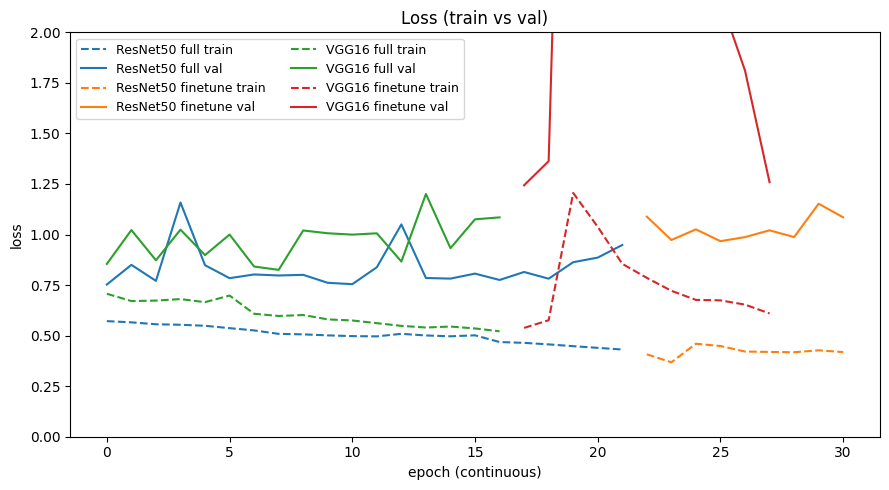

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/loss_train_vs_val_v6_compare.png


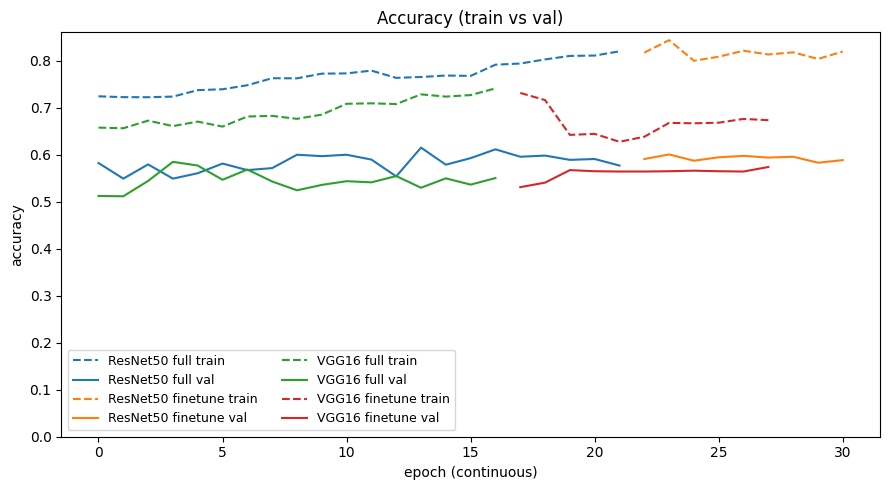

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/acc_train_vs_val_v6_compare.png


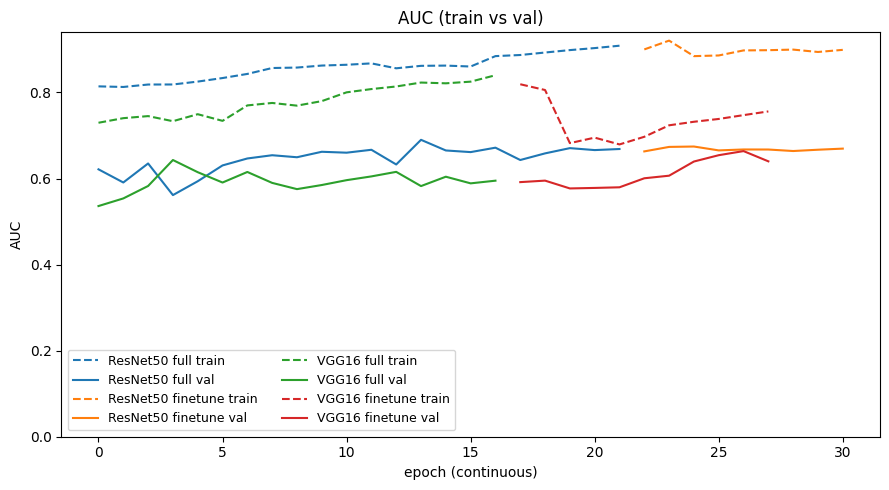

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/auc_train_vs_val_v6_compare.png
207/207 [==============================] - 117s 554ms/step


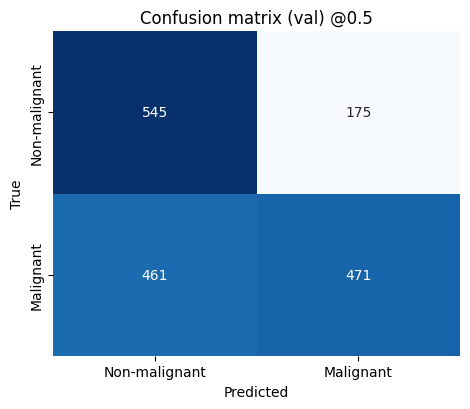

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/confusion_matrix_val_v6.png


In [22]:
# Cell 15 — Evaluation

# Warm-up comparison (AUC & Accuracy)
warmup_csv = METRICS_DIR / "baseline_compare_v6.csv"

wb = pd.read_csv(warmup_csv).copy()
wb["backbone"] = wb["backbone"].str.lower()
wb = wb[wb["backbone"].isin(["vgg16","resnet50"])].set_index("backbone")[["val_auc","val_acc"]]
ix = ["vgg16","resnet50"]
vals = wb.loc[ix].values.T  # rows: metrics, cols: backbones
x = np.arange(len(ix)); w = 0.35
plt.figure(figsize=(6.8,4.2))
plt.bar(x - w/2, vals[0], width=w, label="AUC")
plt.bar(x + w/2, vals[1], width=w, label="Accuracy")
plt.xticks(x, ["VGG16","ResNet50"])
plt.ylim(0, 1.0)
plt.ylabel("Validation score"); plt.title("Warm-up backbone comparison (AUC & Accuracy)")
plt.legend(); plt.tight_layout()
out = PLOTS_DIR / "warmup_backbone_compare_auc_acc_v6.png"
plt.savefig(out, dpi=160); plt.show(); print("Saved ->", out)

def read_log(fp):
    if not fp.exists(): return None
    d = pd.read_csv(fp).copy()
    if "epoch" not in d: d["epoch"] = np.arange(len(d))
    return d

# files
# ResNet50
rsn_full_files = [METRICS_DIR/"train_full_log_v6.csv",
                  METRICS_DIR/"train_full_log_v6_resume.csv"]
rsn_ft_file    =  METRICS_DIR/"train_full_log_v6_finetune.csv"

# VGG16
vgg_full_files = [METRICS_DIR/"train_full_log_v6_vgg16.csv",
                  METRICS_DIR/"train_full_log_v6_vgg16_resume.csv"]
vgg_ft_file    =  METRICS_DIR/"train_full_log_v6_vgg16_finetune.csv"

logs = []

# ----- ResNet: full + finetune 
rsn_full = [x for x in map(read_log, rsn_full_files) if x is not None]
if rsn_full:
    rsn_full_cat = pd.concat(rsn_full, ignore_index=True)
    rsn_full_cat["model"], rsn_full_cat["phase_key"], rsn_full_cat["phase"] = "ResNet50", "full", "ResNet full"
    rsn_full_cat["epoch_in_phase"] = rsn_full_cat["epoch"]
    rsn_full_cat["epoch_cum"]      = rsn_full_cat["epoch"]
    logs.append(rsn_full_cat)

    rsn_full_len = len(rsn_full_cat)
    d = read_log(rsn_ft_file)
    if d is not None:
        d["model"], d["phase_key"], d["phase"] = "ResNet50", "finetune", "ResNet finetune"
        d["epoch_in_phase"] = d["epoch"]
        d["epoch_cum"]      = d["epoch"] + rsn_full_len
        logs.append(d)

# VGG16: full + finetune
vgg_full_len, vgg_parts = 0, []
for f in vgg_full_files:
    d = read_log(f)
    if d is None: continue
    d["epoch_in_phase"] = d["epoch"]
    d["epoch_cum"]      = d["epoch"] + vgg_full_len
    vgg_full_len += len(d)
    vgg_parts.append(d)
if vgg_parts:
    vgg_full_cat = pd.concat(vgg_parts, ignore_index=True)
    vgg_full_cat["model"], vgg_full_cat["phase_key"], vgg_full_cat["phase"] = "VGG16", "full", "VGG16 full"
    logs.append(vgg_full_cat)

    d = read_log(vgg_ft_file)
    if d is not None:
        d["model"], d["phase_key"], d["phase"] = "VGG16", "finetune", "VGG16 finetune"
        d["epoch_in_phase"] = d["epoch"]
        d["epoch_cum"]      = d["epoch"] + vgg_full_len
        logs.append(d)

logs = pd.concat(logs, ignore_index=True)
logs.to_csv(METRICS_DIR/"train_logs_merged_v6_compare.csv", index=False)

# summary (best by val_auc)
rows = []
for (m, ph), g in logs.groupby(["model", "phase"], sort=False):
    b = g.loc[g["val_auc"].idxmax()]
    rows.append({
        "model": m, "phase": ph, "epochs_run": len(g),
        "best_epoch_in_phase": int(b["epoch_in_phase"]),
        "best_epoch_cum":      int(b["epoch_cum"]),
        "best_val_auc":        float(b["val_auc"]),
        "best_val_accuracy":   float(b["val_accuracy"]),
        "best_val_loss":       float(b["val_loss"]),
    })
summary = pd.DataFrame(rows)
summary.to_csv(METRICS_DIR/"phase_summary_v6_compare.csv", index=False)
summary

# plots
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
phase_colors = {
    ("ResNet50","full"):     "tab:blue",
    ("ResNet50","finetune"): "tab:orange",
    ("VGG16","full"):        "tab:green",
    ("VGG16","finetune"):    "tab:red",
}

def plot_pair(tr_col, val_col, title, ylabel, fname, y_top=None):
    plt.figure(figsize=(9,5))
    for (m, phk), g in logs.groupby(["model","phase_key"], sort=False):
        if g.empty: continue
        c = phase_colors[(m, phk)]
        name = f"{m} {'full' if phk=='full' else 'finetune'}"
        plt.plot(g["epoch_cum"], g[tr_col], "--", color=c, label=f"{name} train")
        plt.plot(g["epoch_cum"], g[val_col], "-",  color=c, label=f"{name} val")
    plt.xlabel("epoch (continuous)"); plt.ylabel(ylabel); plt.title(title)
    if y_top is not None: plt.ylim(0.0, y_top)
    else: plt.ylim(bottom=0.0)
    plt.legend(ncol=2, fontsize=9); plt.tight_layout()
    out = PLOTS_DIR/fname; plt.savefig(out, dpi=160); plt.show(); print("Saved ->", out)

plot_pair("loss",     "val_loss",     "Loss (train vs val)",     "loss",     "loss_train_vs_val_v6_compare.png", y_top=2.0)
plot_pair("accuracy", "val_accuracy", "Accuracy (train vs val)", "accuracy", "acc_train_vs_val_v6_compare.png")
plot_pair("auc",      "val_auc",      "AUC (train vs val)",      "AUC",      "auc_train_vs_val_v6_compare.png")

# confusion matrix on best final model (ResNet50 v6)
model = tf.keras.models.load_model(MODELS_DIR/"best_model_full_v6_resume.keras", compile=False)
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0).ravel().astype(int)
y_prob = model.predict(val_ds, verbose=1).ravel()
y_pred = (y_prob >= 0.5).astype(int)
pd.DataFrame({"true":y_true, "prob":y_prob, "pred@0.5":y_pred}).to_csv(METRICS_DIR/"val_predictions_v6.csv", index=False)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(4.8,4.2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-malignant","Malignant"], yticklabels=["Non-malignant","Malignant"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (val) @0.5")
plt.tight_layout()
out = PLOTS_DIR/"confusion_matrix_val_v6.png"
plt.savefig(out, dpi=160); plt.show(); print("Saved ->", out)

## 16: Grad-CAM

Grad-CAM saved: 12 pairs -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/gradcam_v6
Grad-CAM layer: conv5_block3_out


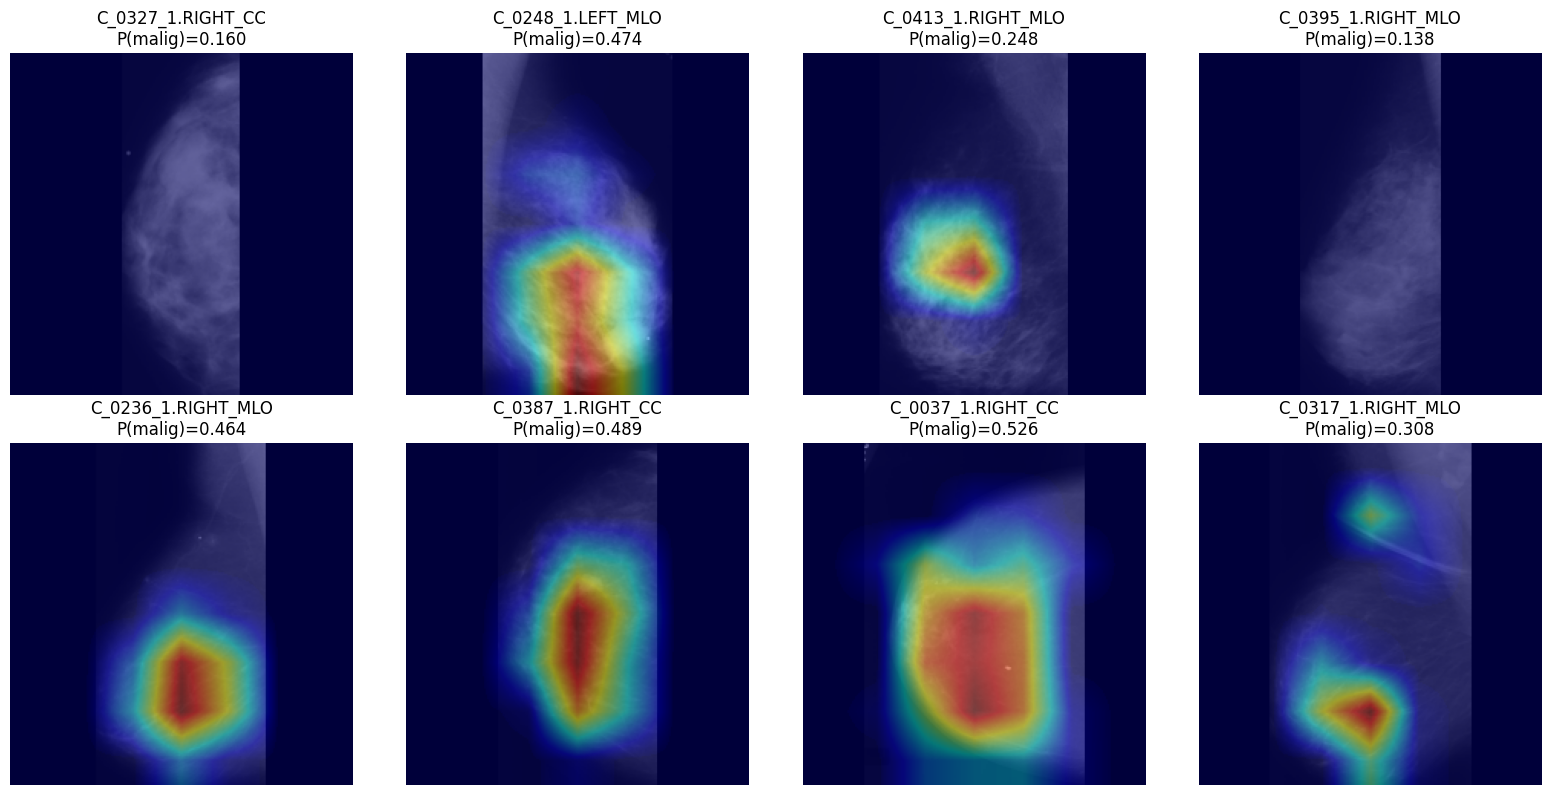

In [20]:
# Cell 16 — Grad-CAM v6

out_dir = VQC_DIR / "gradcam_v6"
out_dir.mkdir(parents=True, exist_ok=True)

model = tf.keras.models.load_model(MODELS_DIR / "best_model_full_v6_resume.keras", compile=False)
LAST_CONV = ("block5_conv3" if any(l.name == "block5_conv3" for l in model.layers)
             else ("conv5_block3_out" if any(l.name == "conv5_block3_out" for l in model.layers)
                   else next((l.name for l in reversed(model.layers) if isinstance(l, Conv2D)), None)))
if LAST_CONV is None: raise RuntimeError("No Conv2D layers -> Grad-CAM not possible.")
grad_model = tf.keras.Model(model.inputs, [model.get_layer(LAST_CONV).output, model.output])

# sample validation images from the manifest
val_paths = pd.read_csv(METRICS_DIR / "split_manifest_v6.csv")
val_paths = val_paths.loc[val_paths["split"]=="val","image_path"].dropna()
val_paths = val_paths.sample(n=min(12, len(val_paths)), random_state=SEED).tolist()

def _letterbox(g, size):
    W, H = size
    h, w = g.shape[:2]
    r = min(W/max(w,1), H/max(h,1))
    nw, nh = max(1,int(w*r)), max(1,int(h*r))
    rsz = cv2.resize(g, (nw, nh), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((H, W), dtype=rsz.dtype)
    y0, x0 = (H-nh)//2, (W-nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = rsz
    return canvas

def gradcam(path_str):
    g = cv2.imread(str(path_str), cv2.IMREAD_GRAYSCALE)
    if g is None: return None, None, None
    g = trim_borders(g)
    g = _letterbox(g, IMG_SIZE)
    g01  = g.astype("float32") / 255.0
    disp = cv2.cvtColor((g01 * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    x3 = np.stack([g01, g01, g01], axis=-1)
    xb = vgg_preprocess(x3[None, ...] * 255.0)

    with tf.GradientTape() as tape:
        conv, pred = grad_model(xb, training=False)
        loss = pred[:, 0]
    grads = tape.gradient(loss, conv)
    w     = tf.reduce_mean(grads, axis=(1, 2))[0]
    cam   = tf.reduce_sum(conv[0] * w[None, None, :], axis=-1).numpy()
    cam   = np.maximum(cam, 0)
    cam   = cv2.resize(cam, (disp.shape[1], disp.shape[0]), interpolation=cv2.INTER_LINEAR)
    cam   = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam[cam < 0.02] = 0.0

    heat    = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heat, 0.45, disp, 0.55, 0)
    return disp, overlay, float(pred.numpy().ravel()[0])

saved, previews = 0, []
for ip in val_paths:
    disp, ov, p = gradcam(ip)
    if disp is None: continue
    stem = Path(ip).stem
    cv2.imwrite(str(out_dir / f"{stem}_disp_v6.png"),    disp)
    cv2.imwrite(str(out_dir / f"{stem}_gradcam_v6.png"), ov)
    if len(previews) < 8:
        previews.append((ov, stem, p))
    saved += 1

print(f"Grad-CAM saved: {saved} pairs -> {out_dir}")
print("Grad-CAM layer:", LAST_CONV)

# Preview
import math, matplotlib.pyplot as plt
n, cols = len(previews), 4
rows = max(1, math.ceil(n / cols))
plt.figure(figsize=(4*cols, 4*rows))
for i, (img_bgr, stem, prob) in enumerate(previews, 1):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img_rgb); ax.axis("off")
    ax.set_title(f"{stem}\nP(malig)={prob:.3f}")
plt.tight_layout(); plt.show() 



Saved panels: 10


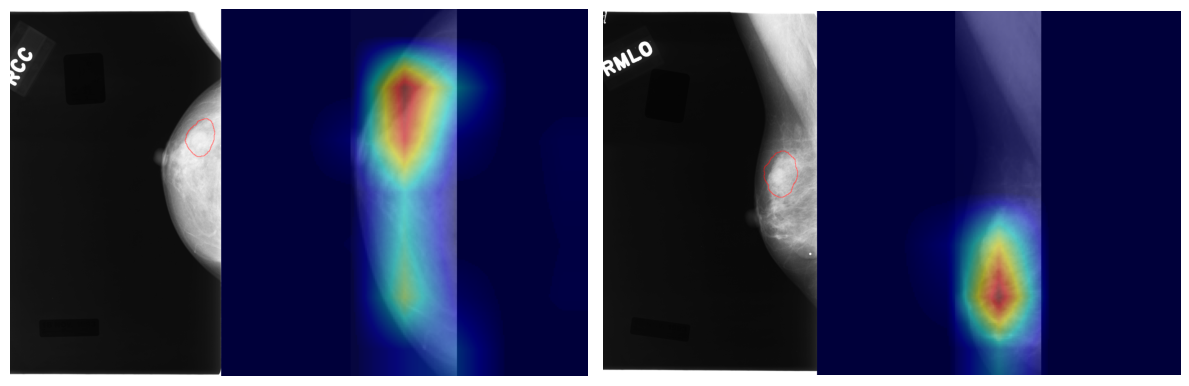

In [ ]:
# Cell 16b — Panels (Mask overlay vs Grad-CAM) — simple

N_PANELS = 10
PANEL_DIR = VQC_DIR / "mask_vs_gradcam_v6"; PANEL_DIR.mkdir(parents=True, exist_ok=True)
mdir, gdir = VQC_DIR / "mask_overlays_v6", VQC_DIR / "gradcam_v6"
mf = pd.read_csv(METRICS_DIR / "mask_qc_v6.csv")
stem2ip = {Path(p).stem: p for p in mf["image_path"].dropna()}

def resize_h(img, h):
    r = h / img.shape[0]
    return cv2.resize(img, (max(1, int(img.shape[1]*r)), h), interpolation=cv2.INTER_AREA)

saved = 0
for f in sorted(mdir.glob("*_overlay_v6.png"))[:N_PANELS]:
    k = f.stem.replace("_overlay_v6","")
    gpath = gdir / f"{k}_gradcam_v6.png"
    if not gpath.exists() and k in stem2ip:
        _, gc, _ = gradcam(stem2ip[k])
        if gc is not None: cv2.imwrite(str(gpath), gc)
    a = cv2.imread(str(f)); b = cv2.imread(str(gpath))
    if a is None or b is None: continue
    b = resize_h(b, a.shape[0])
    cv2.imwrite(str(PANEL_DIR / f"{k}_panel_v6.png"), np.concatenate([a, b], 1)); saved += 1
print("Saved panels:", saved)

# Preview
files = sorted(PANEL_DIR.glob("*_panel_v6.png"))[2:4]
if files:
    plt.figure(figsize=(12, 4))
    for i, fp in enumerate(files, 1):
        img = cv2.cvtColor(cv2.imread(str(fp)), cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, len(files), i); ax.imshow(img); ax.axis("off")
    plt.tight_layout(); plt.show()

## 17: Export artifacts for UI

In [ ]:
# Cell 17 — Export artifacts for the UI (v6)

import json, shutil, tensorflow as tf

APP_DIR = ROOT / "streamlit_app" / "app_bundle_v6"
APP_DIR.mkdir(parents=True, exist_ok=True)

# model bundle
model_src = MODELS_DIR / "best_model_full_v6_resume.keras"
if not model_src.exists():
    raise FileNotFoundError(f"Model not found: {model_src}")
model_dst = APP_DIR / "model.keras"
shutil.copy2(model_src, model_dst)

# config
m = tf.keras.models.load_model(model_src, compile=False)
try:
    last_conv = next(l.name for l in reversed(m.layers) if isinstance(l, tf.keras.layers.Conv2D))
except StopIteration:
    last_conv = "block5_conv3"

config = {
    "img_size": [int(IMG_SIZE[0]), int(IMG_SIZE[1])],
    "last_conv": last_conv,
    "class_names": ["Non-malignant", "Malignant"],
    "threshold": 0.5,
    "preprocess": "vgg",
    "letterbox": True
}
(APP_DIR / "config.json").write_text(json.dumps(config, indent=2))
print("App bundle created ->", APP_DIR)
print(" -", (APP_DIR / "model.keras").name)
print(" -", (APP_DIR / "config.json").name)

dst = APP_DIR / "model_saved"
if dst.exists(): shutil.rmtree(dst)
tf.saved_model.save(m, str(dst))
print("SavedModel exported to:", dst)

App bundle created -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/streamlit_app/app_bundle_v6
 - model.keras
 - config.json
SavedModel exported to: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/streamlit_app/app_bundle_v6/model_saved
